**Test de k-means sur séries temporelles**



In [2]:
#Importation des modules nécessaires
import os
import re
from scipy import spatial
import numpy as np
import math
import fastdtw as dtw
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import rasterio as rio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cookie_clusters import *

In [19]:
pixels_de_interet, dic_de_pixels = create_dic_pixels()

In [3]:
dir = "../../ressources/images"
images_list = os.listdir(dir)

images_2A = list()
images_2B = list()
prog = re.compile(r'\w+2A')
for image in images_list:
    if prog.match(image):
        images_2A.append(image)
    else:
        images_2B.append(image)
        
images_2A.sort()
images_2B.sort()
all_images = images_2A + images_2B
all_images = sorted(all_images, key=lambda date: date[16:24])

In [4]:
list_to_use = all_images
line = 0
matrice_cubique = np.zeros((len(pixels_de_interet), len(list_to_use), 4))
for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        band1 = ds.read(1) # Nir
        band2 = ds.read(2) # Rouge  
        band3 = ds.read(3) # Vert
        band4 = ds.read(4) # Bleu
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice_cubique[j,line,0] = band1[pixel[0], pixel[1]]
        matrice_cubique[j,line,1] = band2[pixel[0], pixel[1]]
        matrice_cubique[j,line,2] = band3[pixel[0], pixel[1]]
        matrice_cubique[j,line,3] = band4[pixel[0], pixel[1]]
    line +=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(54, 141, 4)


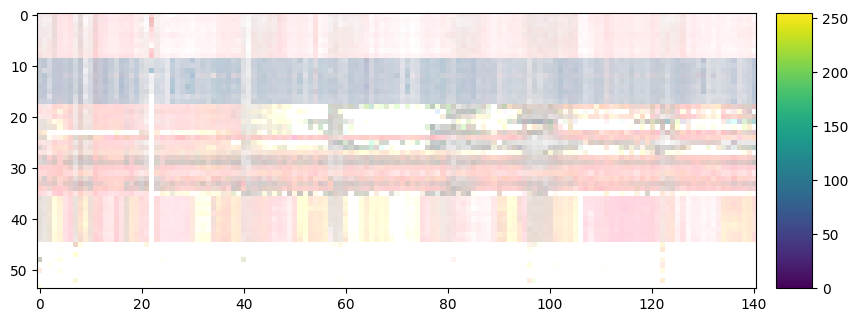

In [5]:
print(matrice_cubique.shape)
#Looking for a pixels
img = (matrice_cubique/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

'image chelou = 22'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Axes(0.125,0.11;0.775x0.77)


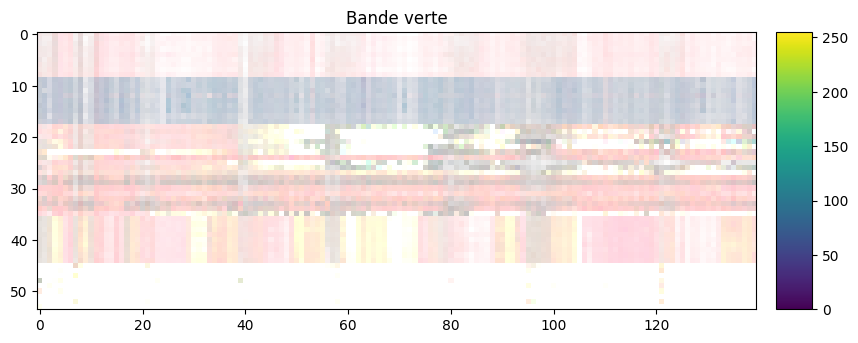

In [6]:
display(f'image chelou = {22}')
matrice = np.delete(matrice_cubique,22,1)
# Displaying pixels
img = (matrice/8).astype(int)
plt.figure(figsize=(10,10))
plt.title('Bande verte')
ax = plt.gca()
print(plt.gca())
im = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

Ici on travaille sur des données multivariées, donc une liste de séries temporelles, avec chaque série temporelle composée de T vecteurs de 4 valeurs (=4 bandes pour chaque pixel).
T = nombre d'élements dans chaque série temporelles (donc nombre d'images)
Le nombre de séries temporelles correspond au nombre de pixels sur une image.

In [7]:

# # Regrouper les séquences dans une liste
# data = [[[1,2,3,5],[10,23,4,8],[5,8,9,2],[4,2,12,4]], [[1,8,3,7],[9,11,14,21],[5,5,7,8],[4,3,3,5]], [[2,1,2,10],[3,10,3,7],[2,5,8,19],[1,4,9,20]]]
# #data = [sequence1,sequence2,sequence3,sequence4]
# data=np.array(data)
# #data=data.reshape((4,6,1))

# print("Nombre de pixels dans chaque image:",data.shape[0])
# print("Nombre d'images:",data.shape[1])
# print("Nombre de bandes pour chaque pixel:",data.shape[2])

Nombre de pixels dans chaque image: 3
Nombre d'images: 4
Nombre de bandes pour chaque pixel: 4


In [5]:
data = matrice

NameError: name 'matrice' is not defined

In [9]:
#mesure de similarité dtw entre deux séries temporelles. x = un pixel sur un intervalle de temps
def dtw_euclidien(x, x_prime):
  R=np.zeros((len(x),len(x_prime)))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = spatial.distance.euclidean(x[i], x_prime[j]) ** 2
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1] ** (1/2)

#pour tester avec le cosin
def dtw_cosine(x, x_prime):
  R=np.zeros((x.shape[0],x_prime.shape[0]))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = spatial.distance.cosine(x[i], x_prime[j])
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1]



print("dtw euclidien que j'ai fait:",dtw_euclidien(data[1],data[2]))
print("fastdtw euclidien:",dtw.fastdtw(data[1],data[2],dist=euclidean)[0])
print("dtw cosine que j'ai fait:",dtw_cosine(data[1],data[2]))
print("fastdtw cosine:",dtw.fastdtw(data[1],data[2],dist=cosine)[0])

#scipy.spatial.distance.cdist


dtw euclidien que j'ai fait: 2504.775439036402
fastdtw euclidien: 25511.23897938015
dtw cosine que j'ai fait: 0.058541321945169145
fastdtw cosine: 0.058541321945169145


Ici la fonction matrice prend en entrée une liste de séries temporelles, et fait une matrice de similarité en donnant la distance dtw entre chaque paire de séries temporelles.
Peut être pratique pour faire du clustering. 

In [6]:
def matrice_dtw(X, distance):
  N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
  R=np.zeros((N,N))
  for i in range(N):
    for j in range(N):
        R[i,j]= dtw.fastdtw(X[i],X[j],dist=distance)[0]
  return R

print(matrice_dtw(data, distance=euclidean))

[[     0.          44703.61678453  31393.6202591  ... 742516.73859108
  644915.02503486 769184.26380404]
 [ 44703.61678453      0.          25511.23897938 ... 744249.57623357
  647789.74626232 770055.05450319]
 [ 31393.6202591   25511.23897938      0.         ... 745434.32510165
  648235.71253874 771523.38900109]
 ...
 [742516.73859108 744249.57623357 745434.32510165 ...      0.
  107613.62576952  65049.921647  ]
 [644915.02503486 647789.74626232 648235.71253874 ... 107613.62576952
       0.         123649.56650482]
 [769184.26380404 770055.05450319 771523.38900109 ...  65049.921647
  123649.56650482      0.        ]]


In [11]:
# #pour faire une matrice de similarité : donne la similarité entre toutes les séries temporelles. la matrice X
# def matrice_dtw_euclidien(X):
#   N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
#   R=np.zeros((N,N))
#   for i in range(N):
#     for j in range(N):
#         R[i,j]=dtw_euclidien(X[i],X[j])
#   return R 


# #pour tester avec le cosin
# def matrice_dtw_cosine(X):
#   N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
#   R=np.zeros((N,N))
#   for i in range(N):
#     for j in range(N):
#         R[i,j]=dtw_cosine(X[i],X[j])
#   return R 

# print(matrice_dtw_euclidien(data))
# print(matrice_dtw_cosine(data))


***KMEANS***

In [12]:
# print(kmeans_dtw(data,3,50,euclidean)) # kmeans avec un dtw euclidien
# print(kmeans_dtw(data,3,50,cosine)) # kmeans avec un dtw cosine

In [ ]:
# # Function to implement steps given in the previous section - version pour dtw
# def kmeans_dtw(x, k, no_of_iterations,distance):
#     idx = np.random.choice(len(x), k, replace=False)
#     #print(x)

#     # Randomly choosing Centroids 
#     centroids = x[idx, :]  # Step 1
#     #centroids=centroids.reshape((3,6,1))

#     for _ in range(no_of_iterations):
#         # Finding the distance between centroids and all the data points
#         distances = np.zeros((len(x), k))
#         for i in range(len(x)):
#             for j in range(len(centroids)):
#                 distances[i, j] = dtw.fastdtw(x[i], centroids[j],dist=distance)[0]  # Step 2
#         #print("distances:",distances)

#         # Centroid with the minimum Distance
#         points = np.array([np.argmin(i) for i in distances])  # Step 3, on a le numéro de centroid de chaque point
#         #print("points:",points)
#         # Updating Centroids by taking the mean of the Cluster it belongs to
#         centroids = np.array([x[points == idx].mean(axis=0) for idx in range(k)])  # Updated Centroids, on fait la moyenne

#     # for i in range(0,k):
#     #     print("Cluster",i,":")
#     #     for j in points:
#     #         if (j==i):
#     #             print(x[j])
                

#     return points


# print(kmeans_dtw(data,3,50,euclidean)) # kmeans avec un dtw euclidien
# print(kmeans_dtw(data,3,50,cosine)) # kmeans avec un dtw cosine

[2 0 1]
[1 0 2]


## Chargement des données 

In [43]:
# type(data)
# np.savetxt('../../ressources/data.txt', data.reshape((data.shape[0],data.shape[1]*data.shape[2])))
# data.shape

(54, 140, 4)

In [4]:
data = np.loadtxt('../data/data.txt')
data = data.reshape(54,140,4)
data

array([[[1287.,  315.,  303.,  232.],
        [1075.,  306.,  232.,  189.],
        [1223.,  271.,  223.,  192.],
        ...,
        [2432.,  207.,  279.,  103.],
        [2348.,  194.,  259.,  134.],
        [2928.,   55.,  259.,   79.]],

       [[1045.,  302.,  263.,  222.],
        [1068.,  311.,  251.,  147.],
        [ 971.,  190.,  229.,  137.],
        ...,
        [2820.,  197.,  336.,  121.],
        [2799.,  208.,  321.,  163.],
        [3170.,   71.,  325.,   63.]],

       [[ 843.,  228.,  256.,  205.],
        [ 911.,  246.,  227.,  156.],
        [1242.,  298.,  256.,  184.],
        ...,
        [2703.,  189.,  303.,  109.],
        [2678.,  171.,  299.,  122.],
        [3223.,   58.,  284.,  133.]],

       ...,

       [[3690., 3351., 3155., 2606.],
        [3992., 4021., 3419., 2815.],
        [3925., 3102., 2875., 2483.],
        ...,
        [3714., 3369., 3098., 2727.],
        [3482., 3546., 3228., 2557.],
        [3990., 3950., 3895., 3300.]],

       [[2552.,

In [15]:
matrice_euc = matrice_dtw(data, euclidean)


In [16]:
matrice_cos = matrice_dtw(data, cosine)

KeyboardInterrupt: 

## Kmedoids - euclidien

In [17]:
from sklearn_extra.cluster import KMedoids

clustering_kmedoids_euc = KMedoids(n_clusters=4, metric='precomputed').fit(matrice_euc)
labels_kmedoids_euc = clustering_kmedoids_euc.labels_

print(labels_kmedoids_euc)


[2 1 1 1 1 1 1 2 1 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


***Évaluation et matrice de confusion***


In [19]:
evaluator = evaluator_de_experiences(labels_kmedoids_euc, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

NameError: name 'pixels_de_interet' is not defined

## Kmedoids - cosine

In [ ]:
from sklearn_extra.cluster import KMedoids

clustering_kmedoids_cos = KMedoids(n_clusters=4, metric='precomputed').fit(matrice_cos)
labels_kmedoids_cos = clustering_kmedoids_cos.labels_

print(labels_kmedoids_cos)



***Évaluation et matrice de confusion***


In [ ]:
evaluator = evaluator_de_experiences(labels_kmedoids_cos, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## DBSCAN - euclidien

In [17]:
from sklearn.cluster import DBSCAN

clustering_dbscan_euc = DBSCAN(eps=100000, min_samples=2, metric='precomputed').fit(matrice_dtw(data, euclidean))
labels_dbscan_euc = clustering_dbscan_euc.labels_

print(labels_dbscan_euc)

[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2 -1  2 -1 -1 -1
  3 -1 -1 -1  3  3  3  3  3  3  3 -1  4  4  4  4  4  4  4  4  4  5  5  5
  5  5  5  5  5  5]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,77.359265


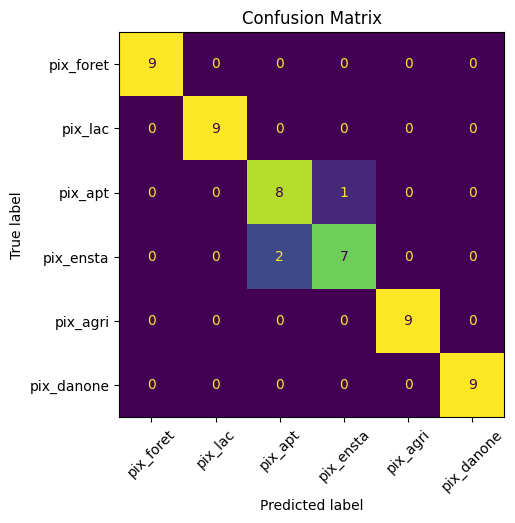

In [20]:
evaluator = evaluator_de_experiences(labels_dbscan_euc, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## DBScan - cosine

In [78]:
matrice_dtw_cos=matrice_dtw(data, distance=cosine)

In [198]:
#matrice de similarité
clustering_dbscan_cos = DBSCAN(eps=1, min_samples=2, metric='precomputed').fit(matrice_dtw_cos)
labels_dbscan_cos = clustering_dbscan_cos.labels_

print(labels_dbscan_cos)

[ 0  0  0  0  0  0  0  0  0  1  1  1 -1  1  1  1  1  1  2  2  2  2  2 -1
  3  2  2  2  3  3  3  3  3  3  3  2  4  4  4  4  4  4  4  4  4  3  3  3
  3  3  3  3  3  3]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,11.273255


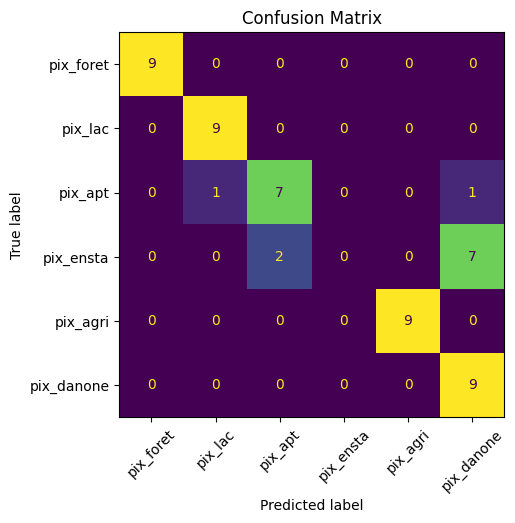

In [200]:
evaluator = evaluator_de_experiences(labels_dbscan_cos, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## OPTICS - euclidien 

In [25]:
from sklearn.cluster import OPTICS

clustering_optics_euc = OPTICS(min_samples=2, metric='precomputed').fit(matrice_dtw(data, distance=euclidean))
labels_optics_euc = clustering_optics_euc.labels_

print(labels_optics_euc)


[ 0  0  0  0  0  0  0  0  0  4  4  4  4  4  4  4  4  4  2  3  2  3  3 -1
 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  6  6  6  5  5  5  5 -1 -1  7 -1 -1
 -1 -1 -1  8  7  8]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,12.72697


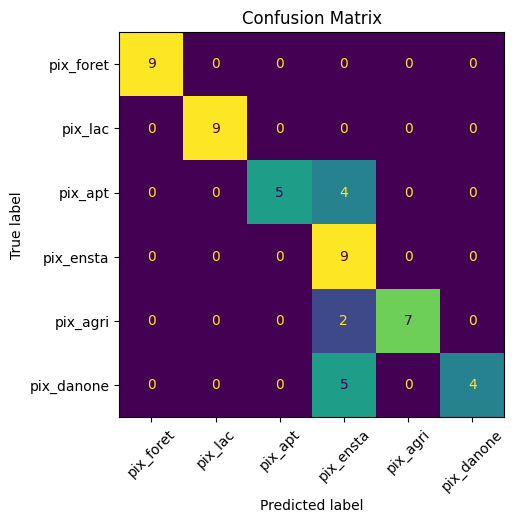

In [26]:
evaluator = evaluator_de_experiences(labels_optics_euc, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## OPTICS - cosine

In [27]:
clustering_optics_cos = OPTICS(min_samples=2, metric='precomputed').fit(matrice_dtw(data, distance=cosine)) #le pb vient du reshaped
labels_optics_cos = clustering_optics_cos.labels_

print(labels_optics_cos)

[ 0  0  0  1  1  2  2  2 -1 10 10 10 10 10 10 10 10 10  6 -1  6 -1 -1 -1
 -1 -1 -1 -1  4  4  3  3 -1  4 -1 -1  7  7  7  8  8  8  8  9  9  5  5  5
  5  5  5  5  5  5]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,31.285951


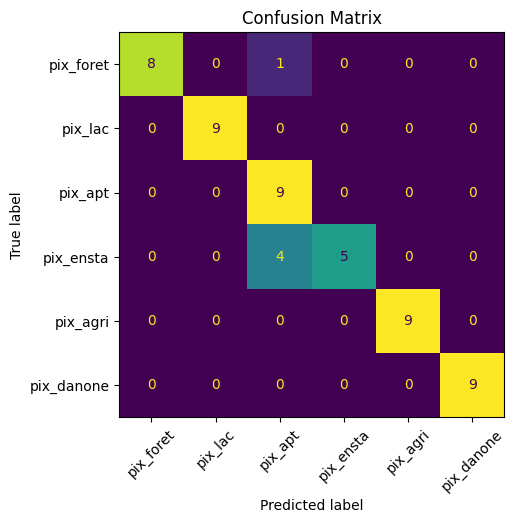

In [28]:
evaluator = evaluator_de_experiences(labels_optics_cos, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## CAH - euclidien


In [44]:
from sklearn.cluster import AgglomerativeClustering

clustering_CAH_euc = AgglomerativeClustering(n_clusters=None,distance_threshold=100000,metric='precomputed', linkage='complete').fit(matrice_dtw(data, euclidean))
labels_CAH_euc = clustering_CAH_euc.labels_
print(labels_CAH_euc)

[ 4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  1 16  1 15 17  7
  8 13 14 11  3  3  2 12  2  3  2 10  6  6  6  6  6  6  6  6  6  0  0  0
  0  0  0  9  0  9]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,133.742088


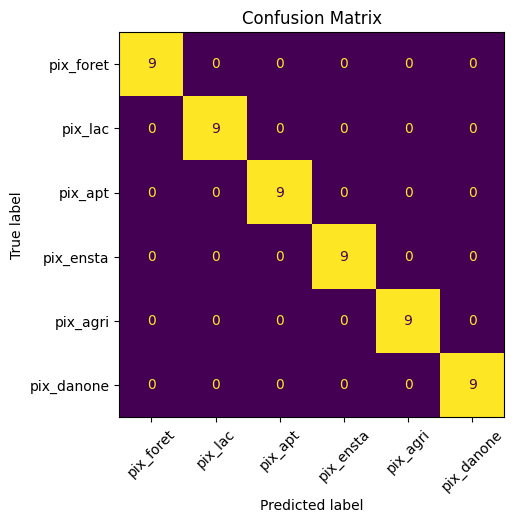

In [46]:
evaluator = evaluator_de_experiences(labels_CAH_euc, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## CAH - cosine


In [201]:
clustering_CAH_cos = AgglomerativeClustering(n_clusters=None, distance_threshold=30,metric='precomputed', linkage='complete').fit(matrice_dtw_cos)
labels_CAH_cos = clustering_CAH_cos.labels_
print(labels_CAH_cos)

[2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2
 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,21.68218


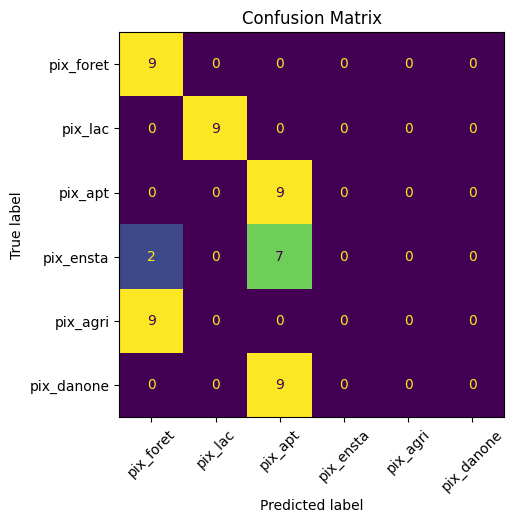

In [202]:
evaluator = evaluator_de_experiences(labels_CAH_cos, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## COSINE sans DTW

On commence par construire les matrices de distance euclidienne et cosine.

In [99]:
# def matrice(X, distance):
#   N=len(X) #nb de pixels dans une image, = nb de séries temporelles qu'on a. chaque série = T vecteurs de 4 bandes
#   R=np.zeros((N,N))
#   for i in range(N):
#     for j in range(N):
#         R[i,j]= distance(X[i],X[j])
#   return R

def matrice_cos(X):
    N = X.shape[0]  # Nombre de séries temporelles
    T = X.shape[1]  # Nombre de vecteurs de 4 bandes dans chaque série temporelle
    R = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            # Aplatir les séries temporelles en vecteurs 1D avant de calculer la distance cosine
            R[i, j] = distance.cosine(X[i].flatten(), X[j].flatten())

    return R

def matrice_euc(X):
    N = X.shape[0]  # Nombre de séries temporelles
    T = X.shape[1]  # Nombre de vecteurs de 4 bandes dans chaque série temporelle
    R = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            # Calculer la distance euclidienne entre les séries temporelles
            R[i, j] = distance.euclidean(X[i].flatten(), X[j].flatten())

    return R

# print(matrice(data, distance=euclidean))
matrice_data_euc=matrice_euc(data)
matrice_data_cos=matrice_cos(data)

In [137]:
print(matrice_data_cos)

[[0.         0.00992699 0.00574719 ... 0.35888794 0.35943421 0.36519528]
 [0.00992699 0.         0.00199287 ... 0.38330355 0.37916858 0.38794409]
 [0.00574719 0.00199287 0.         ... 0.37625976 0.37318866 0.38079115]
 ...
 [0.35888794 0.38330355 0.37625976 ... 0.         0.00598155 0.00402553]
 [0.35943421 0.37916858 0.37318866 ... 0.00598155 0.         0.00631992]
 [0.36519528 0.38794409 0.38079115 ... 0.00402553 0.00631992 0.        ]]


***DBSCAN***

In [203]:
clustering_dbscan = DBSCAN(eps=0.05, min_samples=2, metric='precomputed').fit(matrice_data_cos)
labels_dbscan = clustering_dbscan.labels_

print(labels_dbscan)

[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  2  2  2 -1  2 -1
  3 -1 -1 -1  3  3  3  3  3  3  3 -1  4  4  4  4  4  4  4  4  4  3  3  3
  3  3  3  3  3  3]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,12.244755


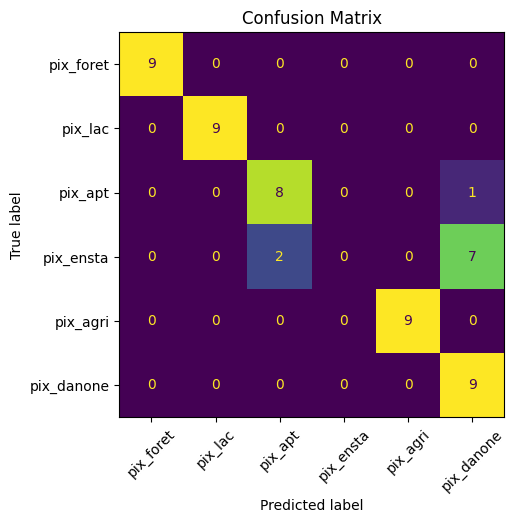

In [204]:
evaluator = evaluator_de_experiences(labels_dbscan, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

***OPTICS***

In [205]:
clustering_optics = OPTICS(min_samples=2, metric='precomputed').fit(matrice_data_cos)
labels_optics= clustering_optics.labels_

***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,9.289983


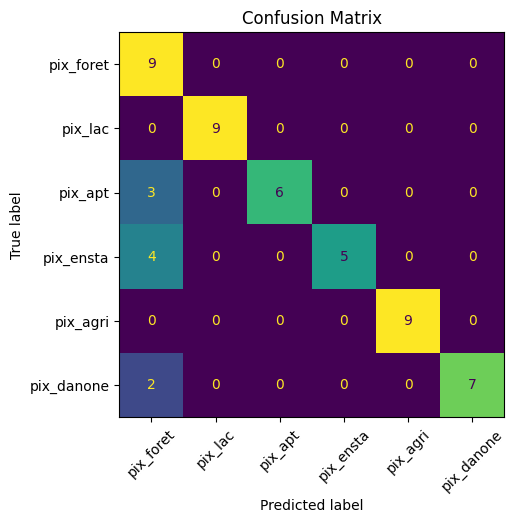

In [206]:
evaluator = evaluator_de_experiences(labels_optics, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

***CAH***

In [207]:
clustering_cah = AgglomerativeClustering(n_clusters=None, distance_threshold=0.05, metric='precomputed', linkage='complete').fit(matrice_data_cos)
labels_cah = clustering_cah.labels_

***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,87.553711


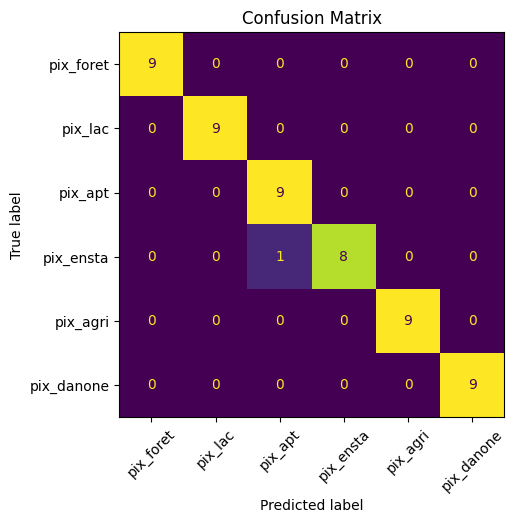

In [208]:
evaluator = evaluator_de_experiences(labels_cah, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

## EUCLIDIEN - SANS DTW

***DBSCAN***

In [210]:
clustering_dbscan = DBSCAN(eps=10000, min_samples=2, metric='precomputed').fit(matrice_data_euc)
labels_dbscan = clustering_dbscan.labels_

print(labels_dbscan)

[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1
  2 -1 -1 -1  2  2  2 -1  2  2  2 -1  3  3  3  3  3  3  3  3  3  4  4  4
  4  4  4  4  4  4]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,84.270253


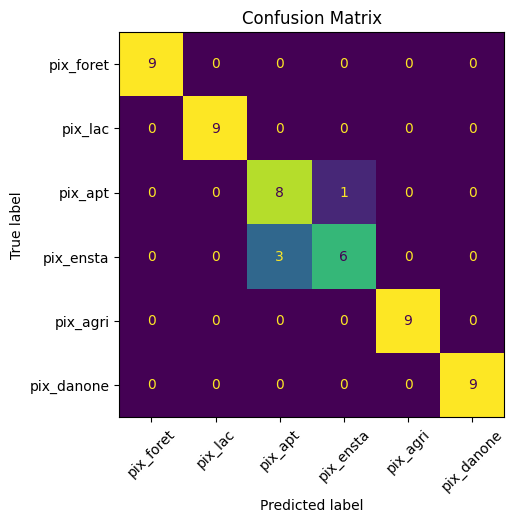

In [211]:
evaluator = evaluator_de_experiences(labels_dbscan, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

***OPTICS***

In [216]:
clustering_optics = OPTICS(min_samples=2, metric='precomputed').fit(matrice_data_euc)
labels_optics= clustering_optics.labels_

***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,13.83321


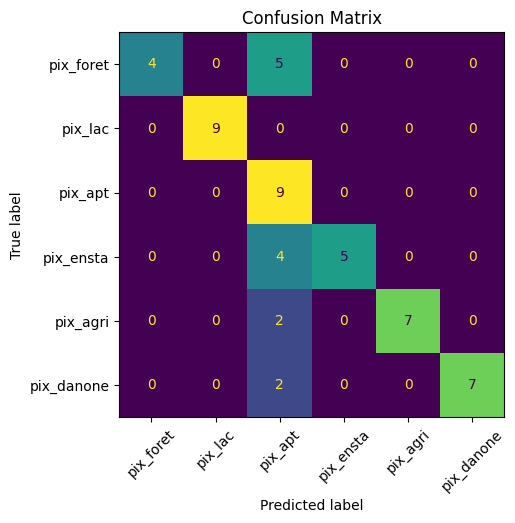

In [213]:
evaluator = evaluator_de_experiences(labels_optics, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()

***CAH***

In [214]:
clustering_cah = AgglomerativeClustering(n_clusters=None, distance_threshold=20000, metric='precomputed', linkage='complete').fit(matrice_data_euc)
labels_cah = clustering_cah.labels_

print(labels_cah)

[7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 3 8 8 1 1 5 4 9 3 1 3 3 4 4 4 3 4 1 2
 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]


***Évaluation et matrice de confusion***

,calinski_harabasz_score
0,90.390898


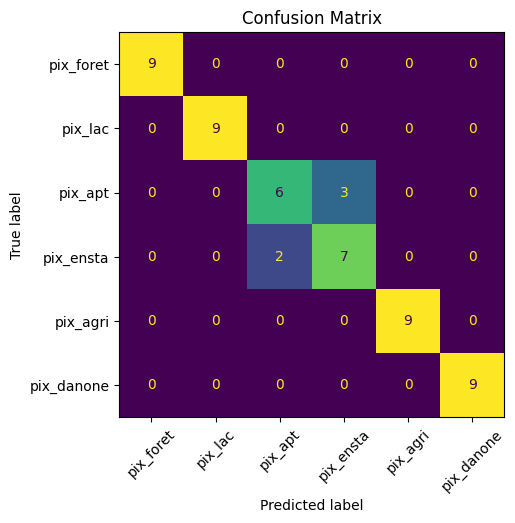

In [215]:
evaluator = evaluator_de_experiences(labels_cah, pixels_de_interet, dic_de_pixels, data.mean(axis=2))
evaluator.confusion_matrix()
evaluator.metrics_clustering()